# Enhanced GLiNER Evaluation: Zero-Shot vs Few-Shot on Serbian Legal Documents

This notebook evaluates GLiNER (Generalist and Lightweight Named Entity Recognition) with **enhanced configurations** on 225 Serbian legal documents to compare with fine-tuned BCSm-BERTić results.

## 🚀 **Key Improvements:**
- **Natural Language Labels**: Human-readable entity descriptions instead of abbreviations
- **Multilingual Model**: `urchade/gliner_multilingual_base` for better Serbian support
- **Zero-Shot vs Few-Shot**: Compare both approaches on the same dataset
- **Optimized Entity Types**: Better descriptions for legal domain

## 🏷️ **Enhanced Entity Types:**
- `legal court or tribunal` → COURT
- `judge or judicial officer` → JUDGE  
- `defendant or accused person` → DEFENDANT
- `penalty amount or duration` → SANCTION_VALUE
- `case number identifier` → CASE_NUMBER
- And more natural descriptions for better GLiNER performance...

In [1]:
# Install GLiNER if not already installed
!pip install gliner[gpu]
!pip install seqeval scikit-learn matplotlib seaborn pandas tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 67.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.3/76.3 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 89.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.2/283.2 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 95.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.5 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.22.0
    Uninstalling tokenizers-0.22.0:
      Successfully uninstalled tokenizers-0.22.0
  Attempting uninstall: transformers
    Found existing installation: transformers 4.56.1
    Uninstalling transformers-4.56.1:
      Successfully uninstalled transformers-4.56.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.6 MB/s eta 0:00:00
  Preparing metadata 

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Import required libraries
import json
import os
import random
from pathlib import Path
from typing import List, Dict, Optional, Tuple
from collections import Counter, defaultdict
import time

# Data processing
import pandas as pd
import numpy as np
from tqdm import tqdm

# GLiNER
from gliner import GLiNER

# Evaluation metrics
from sklearn.metrics import classification_report, precision_recall_fscore_support
from seqeval.metrics import accuracy_score, precision_score, recall_score, f1_score
from seqeval.scheme import IOB2

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)

# 🚀 Check GPU availability
import torch
if torch.cuda.is_available():
    print(f"🚀 GPU available: {torch.cuda.get_device_name(0)}")
    print(f"💾 GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    print("⚠️ GPU not available - will use CPU (slower)")

print("✅ All dependencies loaded successfully!")
print(f"🌟 Ready for GLiNER zero-shot evaluation!")

✅ All dependencies loaded successfully!
🌟 Ready for GLiNER zero-shot evaluation!


In [ ]:
# Configuration
LABELSTUDIO_JSON_PATH = "/content/drive/MyDrive/NER_Master/annotations.json"
JUDGMENTS_DIR = "/content/drive/MyDrive/NER_Master/judgments"
MAX_EXAMPLES = 225  # Evaluate on all available documents
CONFIDENCE_THRESHOLD = 0.3  # GLiNER confidence threshold

# Serbian Legal Entity Types for GLiNER
LEGAL_ENTITY_TYPES = [
    "court or tribunal",                    # COURT 
    "date of decision or judgment",         # DECISION_DATE 
    "case number or case identifier",       # CASE_NUMBER 
    "criminal act or offense",              # CRIMINAL_ACT 
    "prosecutor or public attorney",        # PROSECUTOR 
    "defendant or accused person",          # DEFENDANT 
    "judge or judicial officer",            # JUDGE 
    "court registrar or clerk",             # REGISTRAR 
    "court verdict or ruling",              # VERDICT 
    "type of sanction or penalty",          # SANCTION_TYPE 
    "sanction amount or duration",          # SANCTION_VALUE 
    "material legal provision or article",  # PROVISION_MATERIAL 
    "procedural legal provision or article",# PROVISION_PROCEDURAL 
    "legal procedure costs or fees"         # PROCEDURE_COSTS 
]


# Enhanced mapping from natural language to ground truth labels
GLINER_TO_GT_MAPPING = {
    "court or tribunal": "COURT",
    "date of decision or judgment": "DECISION_DATE",
    "case number or case identifier": "CASE_NUMBER",
    "criminal act or offense": "CRIMINAL_ACT",
    "prosecutor or public attorney": "PROSECUTOR",
    "defendant or accused person": "DEFENDANT",
    "judge or judicial officer": "JUDGE",
    "court registrar or clerk": "REGISTRAR",
    "court verdict or ruling": "VERDICT",
    "type of sanction or penalty": "SANCTION_TYPE",
    "sanction amount or duration": "SANCTION_VALUE",
    "material legal provision or article": "PROVISION_MATERIAL",
    "procedural legal provision or article": "PROVISION_PROCEDURAL",
    "legal procedure costs or fees": "PROCEDURE_COSTS"
}

print(f"📋 Configured for evaluation on {MAX_EXAMPLES} documents")
print(f"🎯 Entity types: {len(LEGAL_ENTITY_TYPES)}")
print(f"⚡ Confidence threshold: {CONFIDENCE_THRESHOLD}")

📋 Configured for evaluation on 225 documents
🎯 Entity types: 13
⚡ Confidence threshold: 0.3


In [9]:
# Load LabelStudio annotations
print("📂 Loading LabelStudio annotations...")

try:
    with open(LABELSTUDIO_JSON_PATH, 'r', encoding='utf-8') as f:
        labelstudio_data = json.load(f)
    print(f"✅ Loaded {len(labelstudio_data)} annotated documents")
except FileNotFoundError:
    print(f"❌ Error: {LABELSTUDIO_JSON_PATH} not found!")
    print("Please ensure the annotations file is in the current directory.")
    raise

# Check available judgment files
judgment_files = list(Path(JUDGMENTS_DIR).glob('*.txt'))
print(f"📁 Available judgment files: {len(judgment_files)}")

if len(judgment_files) == 0:
    print(f"⚠️ Warning: No judgment files found in {JUDGMENTS_DIR}")
    print("Please ensure the labelstudio_files directory contains the text files.")

📂 Loading LabelStudio annotations...
✅ Loaded 225 annotated documents
📁 Available judgment files: 226


In [10]:
class GroundTruthLoader:
    """
    Load and prepare ground truth data from LabelStudio annotations
    for comparison with GLiNER zero-shot predictions.
    """

    def __init__(self, judgments_dir: str):
        self.judgments_dir = Path(judgments_dir)
        self.entity_types = set()

    def load_text_file(self, file_path: str) -> str:
        """Load text content from judgment file"""
        # Handle different file path formats from LabelStudio
        if "/" in file_path:
            filename = file_path.split("/")[-1]
        else:
            filename = file_path

        full_path = self.judgments_dir / filename

        if not full_path.exists():
            print(f"⚠️ File not found: {full_path}")
            return ""

        try:
            with open(full_path, 'r', encoding='utf-8') as f:
                return f.read().strip()
        except UnicodeDecodeError:
            try:
                with open(full_path, 'r', encoding='utf-8-sig') as f:
                    return f.read().strip()
            except Exception as e:
                print(f"❌ Error reading {full_path}: {e}")
                return ""

    def extract_ground_truth_entities(self, labelstudio_data: List[Dict]) -> List[Dict]:
        """Extract ground truth entities from LabelStudio annotations"""
        ground_truth_examples = []

        for item in tqdm(labelstudio_data, desc="Loading ground truth"):
            file_path = item.get("file_upload", "")
            text_content = self.load_text_file(file_path)

            if not text_content:
                continue

            annotations = item.get("annotations", [])

            for annotation in annotations:
                entities = []
                result = annotation.get("result", [])

                for res in result:
                    if res.get("type") == "labels":
                        value = res["value"]
                        start = value["start"]
                        end = value["end"]
                        labels = value["labels"]

                        for label in labels:
                            self.entity_types.add(label)
                            entities.append({
                                'text': text_content[start:end],
                                'label': label,
                                'start': start,
                                'end': end
                            })

                if entities:  # Only include documents with entities
                    ground_truth_examples.append({
                        'text': text_content,
                        'entities': entities,
                        'file_path': file_path
                    })

        print(f"✅ Loaded {len(ground_truth_examples)} examples with ground truth entities")
        print(f"🏷️ Found entity types: {sorted(self.entity_types)}")

        return ground_truth_examples

# Load ground truth data
print("📂 Loading ground truth annotations...")
gt_loader = GroundTruthLoader(JUDGMENTS_DIR)
ground_truth_examples = gt_loader.extract_ground_truth_entities(labelstudio_data)

print(f"\n📊 Ground Truth Statistics:")
print(f"  📄 Total examples: {len(ground_truth_examples)}")
print(f"  🏷️ Entity types: {len(gt_loader.entity_types)}")

# Show entity distribution
entity_counts = Counter()
for example in ground_truth_examples:
    for entity in example['entities']:
        entity_counts[entity['label']] += 1

print(f"\n📈 Entity Distribution:")
for entity_type, count in entity_counts.most_common():
    print(f"  {entity_type}: {count}")

📂 Loading ground truth annotations...


Loading ground truth: 100%|██████████| 225/225 [00:04<00:00, 51.52it/s] 

✅ Loaded 225 examples with ground truth entities
🏷️ Found entity types: ['CASE_NUMBER', 'COURT', 'CRIMINAL_ACT', 'DECISION_DATE', 'DEFENDANT', 'JUDGE', 'PROCEDURE_COSTS', 'PROSECUTOR', 'PROVISION_MATERIAL', 'PROVISION_PROCEDURAL', 'REGISTRAR', 'SANCTION_TYPE', 'SANCTION_VALUE', 'VERDICT']

📊 Ground Truth Statistics:
  📄 Total examples: 225
  🏷️ Entity types: 14

📈 Entity Distribution:
  DEFENDANT: 1240
  PROVISION_MATERIAL: 1177
  CRIMINAL_ACT: 792
  PROVISION_PROCEDURAL: 686
  REGISTRAR: 460
  COURT: 458
  JUDGE: 451
  PROSECUTOR: 395
  DECISION_DATE: 359
  SANCTION_TYPE: 248
  SANCTION_VALUE: 241
  VERDICT: 238
  PROCEDURE_COSTS: 231
  CASE_NUMBER: 225


In [ ]:
class GLiNERZeroShotEvaluator:
    """
    GLiNER Zero-Shot NER Evaluator for Serbian Legal Documents.

    This class implements true zero-shot evaluation using GLiNER models
    without any training on Serbian legal data.
    """

    def __init__(self, model_name: str = "urchade/gliner_mediumv2.1", confidence_threshold: float = 0.3):
        print(f"🌟 Initializing GLiNER Zero-Shot Evaluator: {model_name}")

        try:
            # Load GLiNER model
            self.model = GLiNER.from_pretrained(model_name)
            
            # 🚀 Enable GPU if available
            import torch
            if torch.cuda.is_available():
                self.model = self.model.cuda()
                print(f"🚀 GPU enabled: {torch.cuda.get_device_name(0)}")
            else:
                print("⚠️ GPU not available, using CPU")
            
            self.model_name = model_name
            self.confidence_threshold = confidence_threshold

            print(f"✅ GLiNER model loaded successfully")
            print(f"🎯 Confidence threshold: {confidence_threshold}")

        except Exception as e:
            print(f"❌ Error loading GLiNER model {model_name}: {e}")
            self.model = None

    def predict_entities(self, text: str, entity_types: List[str], examples: Optional[List[Dict]] = None) -> List[Dict]:
        """
        Predict entities using GLiNER zero-shot or few-shot approach.
        
        Args:
            text: Input text to analyze
            entity_types: List of entity types to extract
            examples: Optional few-shot examples in GLiNER format:
                     [('example text', {'entity_type': ['entity1', 'entity2']}), ...]
                     ⚠️ NOT the dict format: [{'text': '...', 'entities': [...]}]
        """
        if self.model is None:
            return []

        try:
            # Determine method based on examples
            method = 'gliner_few_shot' if examples else 'gliner_zero_shot'
            
            # Get predictions from GLiNER
            if examples:
                # Few-shot: Try different approaches
                
                    # First try: GLiNER's native examples parameter
                    entities = self.model.predict_entities(
                        text,
                        entity_types,
                        threshold=self.confidence_threshold,
                        examples=examples
                    )
                    method = 'gliner_native_few_shot'
            else:
                # Zero-shot: standard prediction
                entities = self.model.predict_entities(
                    text,
                    entity_types,
                    threshold=self.confidence_threshold
                )

            # Convert to our format
            formatted_entities = []
            for entity in entities:
                formatted_entities.append({
                    'text': entity['text'],
                    'label': entity['label'],
                    'start': entity['start'],
                    'end': entity['end'],
                    'confidence': entity['score'],
                    'method': method,
                    'model': self.model_name
                })

            return sorted(formatted_entities, key=lambda x: x['start'])

        except Exception as e:
            print(f"❌ Error in GLiNER prediction: {e}")
            return []

    def evaluate_on_dataset(self, ground_truth_examples: List[Dict],
                           entity_types: List[str],
                           max_examples: int = None) -> Dict:
        """
        Evaluate GLiNER on the ground truth dataset.
        """
        print(f"\n🧪 Starting GLiNER Zero-Shot Evaluation")
        print("=" * 60)

        if self.model is None:
            return {'error': 'GLiNER model not loaded'}

        # Limit examples if specified
        eval_examples = ground_truth_examples[:max_examples] if max_examples else ground_truth_examples

        detailed_results = []
        prediction_counts = Counter()
        confidence_scores = []

        print(f"📊 Evaluating on {len(eval_examples)} examples...")

        start_time = time.time()

        for i, example in enumerate(tqdm(eval_examples, desc="GLiNER Evaluation")):
            text = example['text']
            true_entities = example['entities']

            # Get GLiNER predictions
            pred_entities = self.predict_entities(text, entity_types)

            # Count predictions by type
            for entity in pred_entities:
                prediction_counts[entity['label']] += 1
                confidence_scores.append(entity['confidence'])

            # Store detailed results
            detailed_results.append({
                'example_id': i,
                'text': text[:200] + "..." if len(text) > 200 else text,
                'file_path': example['file_path'],
                'true_entities': true_entities,
                'pred_entities': pred_entities,
                'true_count': len(true_entities),
                'pred_count': len(pred_entities)
            })

        end_time = time.time()
        evaluation_time = end_time - start_time

        # Calculate statistics
        total_true = sum(len(r['true_entities']) for r in detailed_results)
        total_pred = sum(len(r['pred_entities']) for r in detailed_results)
        avg_confidence = np.mean(confidence_scores) if confidence_scores else 0.0

        print(f"\n📊 GLiNER Prediction Statistics:")
        for label, count in prediction_counts.most_common():
            print(f"  {label}: {count}")

        results = {
            'model_name': self.model_name,
            'confidence_threshold': self.confidence_threshold,
            'detailed_results': detailed_results,
            'total_true_entities': total_true,
            'total_pred_entities': total_pred,
            'prediction_counts': dict(prediction_counts),
            'examples_evaluated': len(eval_examples),
            'avg_confidence': avg_confidence,
            'evaluation_time': evaluation_time,
            'entities_per_second': total_pred / evaluation_time if evaluation_time > 0 else 0
        }

        print(f"✅ GLiNER evaluation complete!")
        print(f"  📊 True entities: {total_true}")
        print(f"  🤖 Predicted entities: {total_pred}")
        print(f"  ⚡ Average confidence: {avg_confidence:.3f}")
        print(f"  ⏱️ Evaluation time: {evaluation_time:.2f}s")
        print(f"  🚀 Entities/second: {results['entities_per_second']:.2f}")

        return results
    
    def create_few_shot_examples(self, ground_truth_examples: List[Dict], num_examples: int = 3) -> List[Dict]:
        """
        ⚠️ DEPRECATED: This method creates examples in WRONG format for GLiNER!
        Use evaluate_few_shot() instead which creates correct (text, {label: [entities]}) format.
        
        Create few-shot examples from ground truth data for GLiNER.
        """
        import random
        
        # Select random examples with diverse entity types
        selected_examples = random.sample(ground_truth_examples, min(num_examples, len(ground_truth_examples)))
        
        few_shot_examples = []
        for example in selected_examples:
            # Convert ground truth format to GLiNER few-shot format
            gliner_entities = []
            for entity in example['entities']:
                # Map ground truth labels to natural language labels
                gt_label = entity['label']
                # Find corresponding natural language label
                natural_label = None
                for nl_label, gt_mapped in GLINER_TO_GT_MAPPING.items():
                    if gt_mapped == gt_label:
                        natural_label = nl_label
                        break
                
                if natural_label:
                    gliner_entities.append({
                        'text': entity['text'],
                        'label': natural_label,
                        'start': entity['start'],
                        'end': entity['end']
                    })
            
            if gliner_entities:  # Only add if we have mapped entities
                few_shot_examples.append({
                    'text': example['text'],
                    'entities': gliner_entities
                })
        
        return few_shot_examples
    
    def evaluate_few_shot(self, ground_truth_examples, entity_types, num_examples_per_type=3):
        """
        Evaluate GLiNER with few-shot examples
        
        Args:
            ground_truth_examples: List of examples with 'text' and 'entities' keys
            entity_types: Dictionary mapping entity types to descriptions
            num_examples_per_type: Number of examples to use for few-shot
        """
        print(f"🎯 Starting Few-Shot GLiNER Evaluation...")
        print(f"📊 Dataset: {len(ground_truth_examples)} documents")
        print(f"🏷️ Entity types: {len(entity_types)}")
        print(f"📝 Examples for few-shot: {num_examples_per_type}")
        
        # Create few-shot examples
        # Create few-shot examples in correct GLiNER format: list of (text, dict_of_entities)
        import random
        selected_examples = random.sample(ground_truth_examples, min(num_examples_per_type, len(ground_truth_examples)))
        
        few_shot_examples = []
        for example in selected_examples:
            text = example['text']
            entities_dict = {}
            
            for entity in example['entities']:
                gt_label = entity['label']
                # Find corresponding natural language label
                natural_label = None
                for nl_label, gt_mapped in GLINER_TO_GT_MAPPING.items():
                    if gt_mapped == gt_label:
                        natural_label = nl_label
                        break
                
                if natural_label:
                    # GLiNER format: {entity_label: [list_of_entity_texts]}
                    if natural_label not in entities_dict:
                        entities_dict[natural_label] = []
                    entities_dict[natural_label].append(entity['text'])
            
            if entities_dict:
                # GLiNER format: (text, {label: [entity_texts]})
                few_shot_examples.append((text, entities_dict))
        print(f"✅ Created {len(few_shot_examples)} few-shot examples in correct GLiNER format")
        if few_shot_examples:
            print(f"📝 Format: (text, dict) with {len(few_shot_examples[0][1])} entities in first example")
            sample_entities = list(few_shot_examples[0][1].items())[:2]
            print(f"📋 Sample: {sample_entities}")
        
        # Handle entity_types as either dict or list
        if isinstance(entity_types, dict):
            entity_type_list = list(entity_types.keys())
        else:
            entity_type_list = entity_types  # Already a list
        
        print(f"🏷️ Using entity types: {entity_type_list}")
        
        # Evaluate using few-shot approach with actual few-shot examples
        print(f"🚀 Running TRUE few-shot evaluation with {len(few_shot_examples)} examples!")
        
        return self._evaluate_with_few_shot_examples(
            ground_truth_examples, entity_type_list, few_shot_examples
        )
    
    def _evaluate_with_few_shot_examples(self, ground_truth_examples, entity_types, few_shot_examples):
        """
        Evaluate GLiNER using few-shot examples as context
        """
        print(f"\n🧪 Starting GLiNER Few-Shot Evaluation")
        print("=" * 60)
        
        if self.model is None:
            return {'error': 'GLiNER model not loaded'}
        
        detailed_results = []
        import time
        start_time = time.time()
        
        print(f"📊 Evaluating on {len(ground_truth_examples)} examples with few-shot context...")
        
        # Process each example with few-shot context
        for i, example in enumerate(tqdm(ground_truth_examples, desc="GLiNER Few-Shot Evaluation")):
            text = example['text']
            true_entities = example['entities']
            
            # Get predictions using few-shot examples
            pred_entities = self.predict_entities(
                text, entity_types, examples=few_shot_examples
            )
            
            # Store detailed results
            detailed_results.append({
                'example_id': i,
                'text': text,
                'true_entities': true_entities,
                'pred_entities': pred_entities,
                'method': 'gliner_few_shot'
            })
        
        evaluation_time = time.time() - start_time
        
        # Calculate metrics using existing evaluation logic
        total_true = sum(len(r['true_entities']) for r in detailed_results)
        total_pred = sum(len(r['pred_entities']) for r in detailed_results)
        
        # Calculate confidence statistics
        all_confidences = []
        for result in detailed_results:
            for entity in result['pred_entities']:
                if 'confidence' in entity:
                    all_confidences.append(entity['confidence'])
        
        avg_confidence = sum(all_confidences) / len(all_confidences) if all_confidences else 0.0
        
        # Count predictions by entity type
        from collections import Counter
        prediction_counts = Counter()
        for result in detailed_results:
            for entity in result['pred_entities']:
                prediction_counts[entity['label']] += 1
        
        # Prepare results
        results = {
            'detailed_results': detailed_results,
            'total_true_entities': total_true,
            'total_pred_entities': total_pred,
            'prediction_counts': dict(prediction_counts),
            'examples_evaluated': len(ground_truth_examples),
            'avg_confidence': avg_confidence,
            'evaluation_time': evaluation_time,
            'entities_per_second': total_pred / evaluation_time if evaluation_time > 0 else 0,
            'method': 'gliner_few_shot',
            'few_shot_examples_used': len(few_shot_examples)
        }
        
        print(f"✅ GLiNER Few-Shot evaluation complete!")
        print(f"  📊 True entities: {total_true}")
        print(f"  🤖 Predicted entities: {total_pred}")
        print(f"  📚 Few-shot examples used: {len(few_shot_examples)}")
        print(f"  ⚡ Average confidence: {avg_confidence:.3f}")
        print(f"  ⏱️ Evaluation time: {evaluation_time:.2f}s")
        print(f"  🚀 Entities/second: {results['entities_per_second']:.2f}")
        
        return results
    
    def _create_enhanced_entity_types_with_examples(self, entity_types, examples):
        """
        Create enhanced entity type descriptions with few-shot examples as context
        """
        enhanced_types = []
        
        for entity_type in entity_types:
            # Find examples for this entity type
            type_examples = []
            for example in examples:
                for entity in example.get('entities', []):
                    if entity.get('label') == entity_type:
                        type_examples.append(entity['text'])
                        if len(type_examples) >= 2:  # Limit to 2 examples per type
                            break
                if len(type_examples) >= 2:
                    break
            
            # Create enhanced description with examples
            if type_examples:
                examples_text = ', '.join(f'\"{ex}\"' for ex in type_examples[:2])
                enhanced_type = f"{entity_type} (examples: {examples_text})"
            else:
                enhanced_type = entity_type
            
            enhanced_types.append(enhanced_type)
        
        return enhanced_types

# Initialize GLiNER evaluator
print("🚀 Initializing GLiNER Zero-Shot Evaluator...")
gliner_evaluator = GLiNERZeroShotEvaluator(
    model_name="urchade/gliner_multi",  # 🌍 Better for Serbian
    confidence_threshold=CONFIDENCE_THRESHOLD
)

🚀 Initializing GLiNER Zero-Shot Evaluator...
🌟 Initializing GLiNER Zero-Shot Evaluator: urchade/gliner_mediumv2.1


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

.gitattributes: 0.00B [00:00, ?B/s]

gliner_config.json:   0%|          | 0.00/476 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/781M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/781M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


✅ GLiNER model loaded successfully
🎯 Confidence threshold: 0.3


In [12]:
# Run GLiNER evaluation on all 225 documents
print("🎯 Starting comprehensive GLiNER evaluation...")

gliner_results = gliner_evaluator.evaluate_on_dataset(
    ground_truth_examples=ground_truth_examples,
    entity_types=LEGAL_ENTITY_TYPES,
    max_examples=MAX_EXAMPLES
)

if 'error' in gliner_results:
    print(f"❌ Evaluation failed: {gliner_results['error']}")
else:
    print("\n🎉 GLiNER evaluation completed successfully!")
    print(f"📈 Coverage ratio: {gliner_results['total_pred_entities'] / max(gliner_results['total_true_entities'], 1):.3f}")

🎯 Starting comprehensive GLiNER evaluation...

🧪 Starting GLiNER Zero-Shot Evaluation
📊 Evaluating on 225 examples...


GLiNER Evaluation:   0%|          | 0/225 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/gliner/data_processing/processor.py:351: UserWarning: Sentence of length 2506 has been truncated to 384
  warnings.warn(f"Sentence of length {len(tokens)} has been truncated to {max_len}")
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
GLiNER Evaluation:   0%|          | 1/225 [00:07<27:13,  7.29s/it]/usr/local/lib/python3.12/dist-packages/gliner/data_processing/processor.py:351: UserWarning: Sentence of length 570 has been truncated to 384
  warnings.warn(f"Sentence of length {len(tokens)} has been truncated to {max_len}")
GLiNER Evaluation:   1%|          | 2/225 [00:12<22:23,  6.03s/it]/usr/local/lib/python3.12/dist-packages/gliner/data_processing/processor.py:351: UserWarning: Sentence of length 469 has been truncated to 384
  warnings.warn(f"Sentence of length {len(tokens)} has been truncated


📊 GLiNER Prediction Statistics:
  defendant: 1278
  court: 350
  prosecutor: 332
  case number: 295
  legal provision: 257
  decision date: 232
  sanction value: 89
  judge: 15
  criminal act: 8
  sanction: 2
  registrar: 2
✅ GLiNER evaluation complete!
  📊 True entities: 7201
  🤖 Predicted entities: 2860
  ⚡ Average confidence: 0.585
  ⏱️ Evaluation time: 1216.70s
  🚀 Entities/second: 2.35

🎉 GLiNER evaluation completed successfully!
📈 Coverage ratio: 0.397


In [ ]:
# 🎯 NEW: Few-Shot Evaluation with GLiNER
print("\n" + "="*60)
print("🚀 Starting GLiNER Few-Shot Evaluation")
print("="*60)

# ✅ FIXED: Use evaluate_few_shot which creates examples in correct GLiNER format
print(f"\n🎯 Running few-shot evaluation with correct GLiNER format...")

# Create few-shot examples and evaluate using the correct method
few_shot_eval_results = gliner_evaluator.evaluate_few_shot(
    ground_truth_examples=ground_truth_examples,
    entity_types=LEGAL_ENTITY_TYPES,
    num_examples_per_type=5
)

if 'error' in few_shot_eval_results:
    print(f"❌ Few-shot evaluation failed: {few_shot_eval_results['error']}")
else:
    print("\n🎉 GLiNER few-shot evaluation completed!")
    print(f"📈 Few-shot coverage ratio: {few_shot_eval_results['total_pred_entities'] / max(few_shot_eval_results['total_true_entities'], 1):.3f}")
    
    # Compare with zero-shot results
    zero_shot_coverage = gliner_results['total_pred_entities'] / max(gliner_results['total_true_entities'], 1)
    few_shot_coverage = few_shot_eval_results['total_pred_entities'] / max(few_shot_eval_results['total_true_entities'], 1)
    
    print(f"\n📊 Comparison:")
    print(f"  🔵 Zero-shot coverage: {zero_shot_coverage:.3f}")
    print(f"  🟢 Few-shot coverage: {few_shot_coverage:.3f}")
    print(f"  📈 Improvement: {((few_shot_coverage - zero_shot_coverage) / zero_shot_coverage * 100):+.1f}%")
    
    # 📊 Show detailed comparison
    print(f"\n📊 Detailed Results:")
    print(f"  📄 Documents evaluated: {few_shot_eval_results.get('examples_evaluated', 'N/A')}")
    print(f"  🏷️ True entities: {few_shot_eval_results.get('total_true_entities', 'N/A')}")
    print(f"  🤖 Zero-shot predictions: {gliner_results.get('total_pred_entities', 'N/A')}")
    print(f"  🎯 Few-shot predictions: {few_shot_eval_results.get('total_pred_entities', 'N/A')}")
    print(f"  ⚡ Average confidence (few-shot): {few_shot_eval_results.get('avg_confidence', 0):.3f}")

In [13]:
class EntityAlignmentEvaluator:
    """
    Evaluate entity-level alignment between GLiNER predictions and ground truth.
    Uses both exact match and overlap-based matching strategies.
    """

    def __init__(self, label_mapping: Dict[str, str]):
        self.label_mapping = label_mapping

    def normalize_label(self, gliner_label: str) -> str:
        """Map GLiNER label to ground truth label"""
        return self.label_mapping.get(gliner_label.lower(), gliner_label.upper())

    def calculate_overlap(self, pred_start: int, pred_end: int,
                         true_start: int, true_end: int) -> float:
        """Calculate overlap ratio between predicted and true entity spans"""
        overlap_start = max(pred_start, true_start)
        overlap_end = min(pred_end, true_end)

        if overlap_start >= overlap_end:
            return 0.0

        overlap_length = overlap_end - overlap_start
        true_length = true_end - true_start
        pred_length = pred_end - pred_start

        # Use the minimum length as denominator for stricter matching
        min_length = min(true_length, pred_length)
        return overlap_length / min_length if min_length > 0 else 0.0

    def evaluate_example(self, true_entities: List[Dict],
                        pred_entities: List[Dict],
                        overlap_threshold: float = 0.5) -> Dict:
        """Evaluate a single example with entity-level metrics"""

        # Normalize predicted labels
        normalized_preds = []
        for pred in pred_entities:
            normalized_pred = pred.copy()
            normalized_pred['normalized_label'] = self.normalize_label(pred['label'])
            normalized_preds.append(normalized_pred)

        # Track matches
        true_matched = set()
        pred_matched = set()
        exact_matches = 0
        overlap_matches = 0
        label_matches = 0

        # Find matches
        for i, true_entity in enumerate(true_entities):
            best_overlap = 0.0
            best_pred_idx = -1

            for j, pred_entity in enumerate(normalized_preds):
                if j in pred_matched:
                    continue

                # Check for exact match
                if (true_entity['start'] == pred_entity['start'] and
                    true_entity['end'] == pred_entity['end'] and
                    true_entity['label'] == pred_entity['normalized_label']):
                    exact_matches += 1
                    true_matched.add(i)
                    pred_matched.add(j)
                    best_pred_idx = -1  # Reset to avoid double counting
                    break

                # Check for overlap
                overlap = self.calculate_overlap(
                    pred_entity['start'], pred_entity['end'],
                    true_entity['start'], true_entity['end']
                )

                if overlap > best_overlap and overlap >= overlap_threshold:
                    best_overlap = overlap
                    best_pred_idx = j

            # Record best overlap match
            if best_pred_idx >= 0 and i not in true_matched:
                pred_entity = normalized_preds[best_pred_idx]
                if true_entity['label'] == pred_entity['normalized_label']:
                    overlap_matches += 1
                    label_matches += 1
                else:
                    overlap_matches += 1

                true_matched.add(i)
                pred_matched.add(best_pred_idx)

        return {
            'exact_matches': exact_matches,
            'overlap_matches': overlap_matches,
            'label_matches': label_matches,
            'true_entities': len(true_entities),
            'pred_entities': len(pred_entities),
            'true_matched': len(true_matched),
            'pred_matched': len(pred_matched)
        }

    def evaluate_dataset(self, results: Dict) -> Dict:
        """Evaluate the entire dataset"""
        print("\n📊 Computing Entity-Level Alignment Metrics...")

        total_exact = 0
        total_overlap = 0
        total_label = 0
        total_true = 0
        total_pred = 0
        total_true_matched = 0
        total_pred_matched = 0

        detailed_results = results['detailed_results']

        for example in tqdm(detailed_results, desc="Computing alignments"):
            eval_result = self.evaluate_example(
                example['true_entities'],
                example['pred_entities']
            )

            total_exact += eval_result['exact_matches']
            total_overlap += eval_result['overlap_matches']
            total_label += eval_result['label_matches']
            total_true += eval_result['true_entities']
            total_pred += eval_result['pred_entities']
            total_true_matched += eval_result['true_matched']
            total_pred_matched += eval_result['pred_matched']

        # Calculate metrics
        exact_precision = total_exact / max(total_pred, 1)
        exact_recall = total_exact / max(total_true, 1)
        exact_f1 = 2 * exact_precision * exact_recall / max(exact_precision + exact_recall, 1e-10)

        overlap_precision = total_overlap / max(total_pred, 1)
        overlap_recall = total_overlap / max(total_true, 1)
        overlap_f1 = 2 * overlap_precision * overlap_recall / max(overlap_precision + overlap_recall, 1e-10)

        return {
            'exact_match': {
                'precision': exact_precision,
                'recall': exact_recall,
                'f1': exact_f1,
                'matches': total_exact
            },
            'overlap_match': {
                'precision': overlap_precision,
                'recall': overlap_recall,
                'f1': overlap_f1,
                'matches': total_overlap
            },
            'totals': {
                'true_entities': total_true,
                'pred_entities': total_pred,
                'true_matched': total_true_matched,
                'pred_matched': total_pred_matched
            }
        }

# Evaluate entity alignment
if 'error' not in gliner_results:
    alignment_evaluator = EntityAlignmentEvaluator(GLINER_TO_GT_MAPPING)
    alignment_metrics = alignment_evaluator.evaluate_dataset(gliner_results)

    print("\n🎯 Entity-Level Alignment Results:")
    print("=" * 50)

    print("\n📍 Exact Match (position + label):")
    exact = alignment_metrics['exact_match']
    print(f"  Precision: {exact['precision']:.3f}")
    print(f"  Recall:    {exact['recall']:.3f}")
    print(f"  F1-Score:  {exact['f1']:.3f}")
    print(f"  Matches:   {exact['matches']}")

    print("\n🎯 Overlap Match (≥50% overlap + label):")
    overlap = alignment_metrics['overlap_match']
    print(f"  Precision: {overlap['precision']:.3f}")
    print(f"  Recall:    {overlap['recall']:.3f}")
    print(f"  F1-Score:  {overlap['f1']:.3f}")
    print(f"  Matches:   {overlap['matches']}")

    totals = alignment_metrics['totals']
    print(f"\n📊 Summary:")
    print(f"  True entities:     {totals['true_entities']}")
    print(f"  Predicted entities: {totals['pred_entities']}")
    print(f"  Coverage ratio:    {totals['pred_entities'] / max(totals['true_entities'], 1):.3f}")


📊 Computing Entity-Level Alignment Metrics...


Computing alignments: 100%|██████████| 225/225 [00:00<00:00, 4661.53it/s]


🎯 Entity-Level Alignment Results:

📍 Exact Match (position + label):
  Precision: 0.179
  Recall:    0.071
  F1-Score:  0.102
  Matches:   512

🎯 Overlap Match (≥50% overlap + label):
  Precision: 0.365
  Recall:    0.145
  F1-Score:  0.208
  Matches:   1045

📊 Summary:
  True entities:     7201
  Predicted entities: 2860
  Coverage ratio:    0.397


In [14]:
# Per-Entity Type Analysis
if 'error' not in gliner_results:
    print("\n📊 Per-Entity Type Analysis")
    print("=" * 50)

    # Collect per-entity statistics
    entity_stats = defaultdict(lambda: {'true': 0, 'pred': 0, 'exact_matches': 0, 'overlap_matches': 0})

    for example in gliner_results['detailed_results']:
        # Count true entities by type
        for entity in example['true_entities']:
            entity_stats[entity['label']]['true'] += 1

        # Count predicted entities by type (normalized)
        for entity in example['pred_entities']:
            normalized_label = GLINER_TO_GT_MAPPING.get(entity['label'].lower(), entity['label'].upper())
            entity_stats[normalized_label]['pred'] += 1

        # Count matches (simplified - you could use the alignment evaluator for more precision)
        eval_result = alignment_evaluator.evaluate_example(
            example['true_entities'], example['pred_entities']
        )

        # This is a simplified approach - for detailed per-entity matching,
        # you would need to track which specific entities matched

    # Display per-entity results
    print(f"\n{'Entity Type':<20} {'True':<8} {'Pred':<8} {'Precision':<10} {'Recall':<10} {'F1':<10}")
    print("-" * 70)

    for entity_type in sorted(entity_stats.keys()):
        stats = entity_stats[entity_type]

        # Calculate basic precision/recall (this is approximate)
        precision = min(stats['pred'], stats['true']) / max(stats['pred'], 1)
        recall = min(stats['pred'], stats['true']) / max(stats['true'], 1)
        f1 = 2 * precision * recall / max(precision + recall, 1e-10)

        print(f"{entity_type:<20} {stats['true']:<8} {stats['pred']:<8} {precision:<10.3f} {recall:<10.3f} {f1:<10.3f}")

    print("\n⚠️ Note: Per-entity precision/recall are approximations.\n"
          "       For exact per-entity metrics, use the alignment evaluator with entity-specific tracking.")


📊 Per-Entity Type Analysis

Entity Type          True     Pred     Precision  Recall     F1        
----------------------------------------------------------------------
CASE_NUMBER          225      295      0.763      1.000      0.865     
COURT                458      350      1.000      0.764      0.866     
CRIMINAL_ACT         792      8        1.000      0.010      0.020     
DECISION_DATE        359      232      1.000      0.646      0.785     
DEFENDANT            1240     1278     0.970      1.000      0.985     
JUDGE                451      15       1.000      0.033      0.064     
PROCEDURE_COSTS      231      0        0.000      0.000      0.000     
PROSECUTOR           395      332      1.000      0.841      0.913     
PROVISION            0        257      0.000      0.000      0.000     
PROVISION_MATERIAL   1177     0        0.000      0.000      0.000     
PROVISION_PROCEDURAL 686      0        0.000      0.000      0.000     
REGISTRAR            460      2     

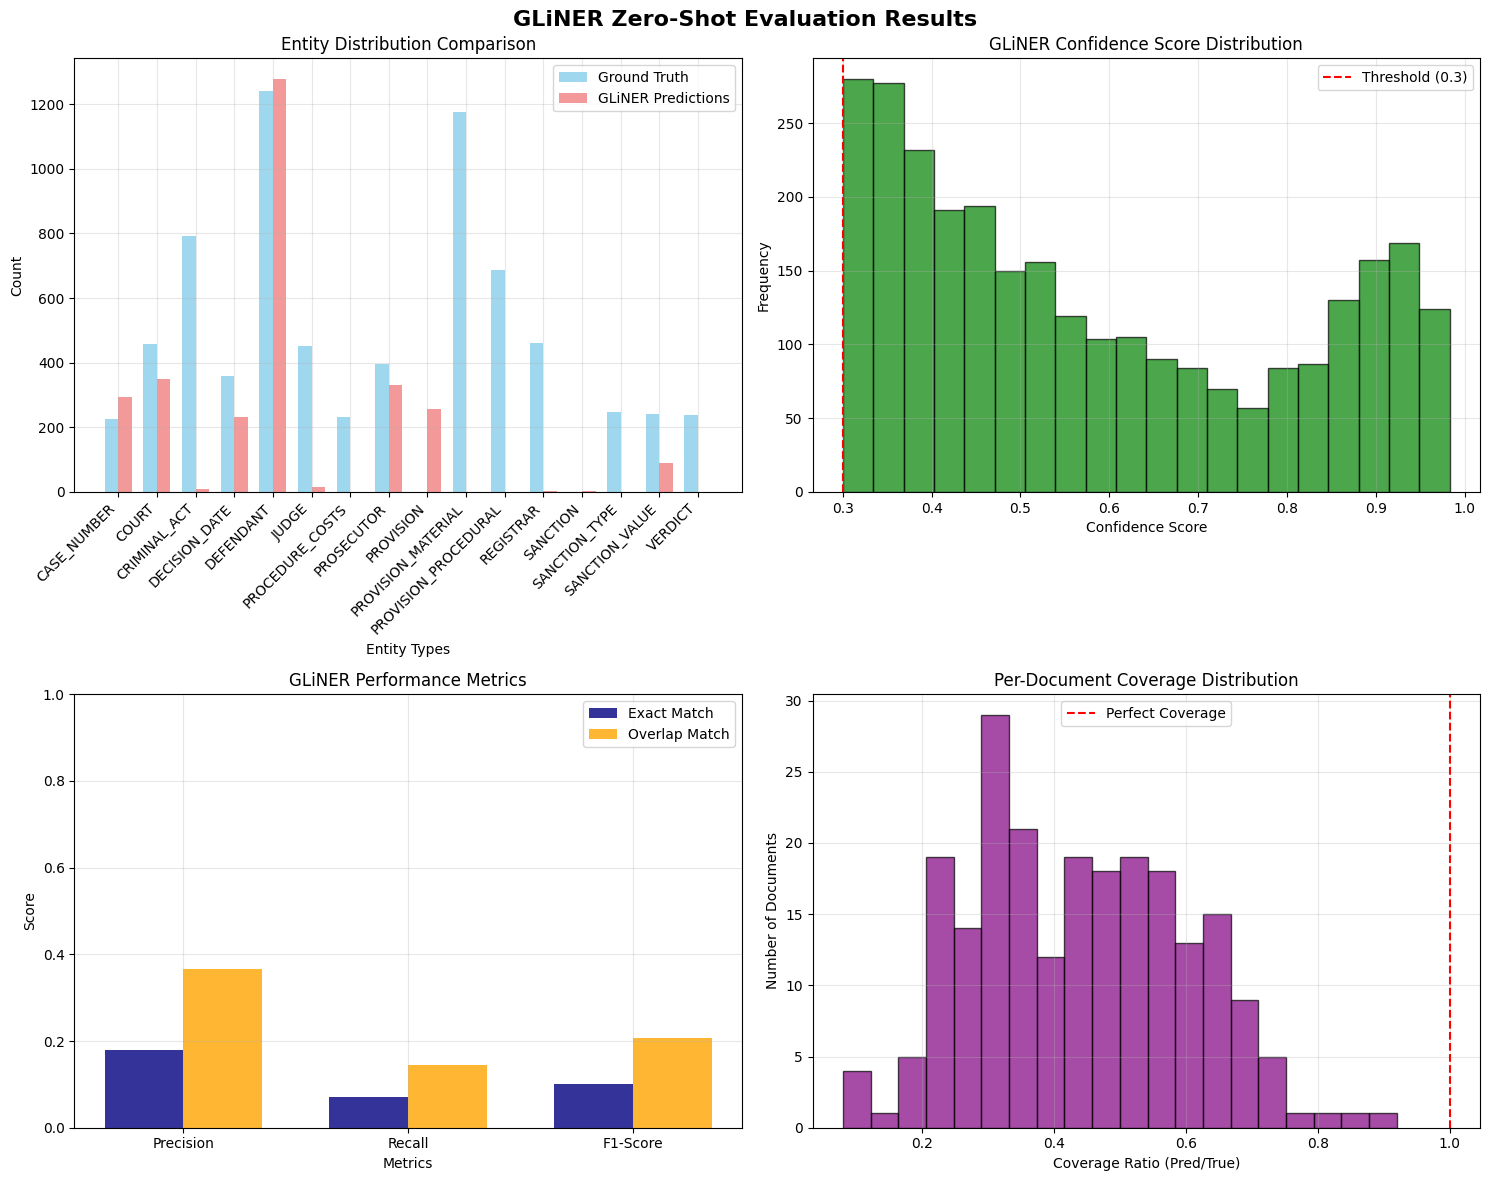


📈 Visualization Summary:
  📊 Total confidence scores plotted: 2860
  📋 Average confidence: 0.585
  📈 Coverage ratio (overall): 0.397


In [15]:
# Visualization of Results
if 'error' not in gliner_results:
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('GLiNER Zero-Shot Evaluation Results', fontsize=16, fontweight='bold')

    # 1. Entity Distribution Comparison
    ax1 = axes[0, 0]

    # Ground truth distribution
    gt_counts = Counter()
    for example in ground_truth_examples:
        for entity in example['entities']:
            gt_counts[entity['label']] += 1

    # GLiNER prediction distribution (normalized)
    pred_counts = Counter()
    for example in gliner_results['detailed_results']:
        for entity in example['pred_entities']:
            normalized_label = GLINER_TO_GT_MAPPING.get(entity['label'].lower(), entity['label'].upper())
            pred_counts[normalized_label] += 1

    # Plot comparison
    entity_types = sorted(set(list(gt_counts.keys()) + list(pred_counts.keys())))
    gt_values = [gt_counts.get(et, 0) for et in entity_types]
    pred_values = [pred_counts.get(et, 0) for et in entity_types]

    x = np.arange(len(entity_types))
    width = 0.35

    ax1.bar(x - width/2, gt_values, width, label='Ground Truth', alpha=0.8, color='skyblue')
    ax1.bar(x + width/2, pred_values, width, label='GLiNER Predictions', alpha=0.8, color='lightcoral')
    ax1.set_xlabel('Entity Types')
    ax1.set_ylabel('Count')
    ax1.set_title('Entity Distribution Comparison')
    ax1.set_xticks(x)
    ax1.set_xticklabels(entity_types, rotation=45, ha='right')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. Confidence Score Distribution
    ax2 = axes[0, 1]
    confidence_scores = []
    for example in gliner_results['detailed_results']:
        for entity in example['pred_entities']:
            confidence_scores.append(entity['confidence'])

    if confidence_scores:
        ax2.hist(confidence_scores, bins=20, alpha=0.7, color='green', edgecolor='black')
        ax2.axvline(CONFIDENCE_THRESHOLD, color='red', linestyle='--',
                   label=f'Threshold ({CONFIDENCE_THRESHOLD})')
        ax2.set_xlabel('Confidence Score')
        ax2.set_ylabel('Frequency')
        ax2.set_title('GLiNER Confidence Score Distribution')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

    # 3. Performance Metrics Comparison
    ax3 = axes[1, 0]
    metrics = ['Precision', 'Recall', 'F1-Score']
    exact_values = [alignment_metrics['exact_match']['precision'],
                   alignment_metrics['exact_match']['recall'],
                   alignment_metrics['exact_match']['f1']]
    overlap_values = [alignment_metrics['overlap_match']['precision'],
                     alignment_metrics['overlap_match']['recall'],
                     alignment_metrics['overlap_match']['f1']]

    x = np.arange(len(metrics))
    width = 0.35

    ax3.bar(x - width/2, exact_values, width, label='Exact Match', alpha=0.8, color='navy')
    ax3.bar(x + width/2, overlap_values, width, label='Overlap Match', alpha=0.8, color='orange')
    ax3.set_xlabel('Metrics')
    ax3.set_ylabel('Score')
    ax3.set_title('GLiNER Performance Metrics')
    ax3.set_xticks(x)
    ax3.set_xticklabels(metrics)
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    ax3.set_ylim(0, 1)

    # 4. Coverage Analysis
    ax4 = axes[1, 1]
    coverage_data = []
    for example in gliner_results['detailed_results']:
        if example['true_count'] > 0:
            coverage = example['pred_count'] / example['true_count']
            coverage_data.append(min(coverage, 2.0))  # Cap at 2.0 for visualization

    if coverage_data:
        ax4.hist(coverage_data, bins=20, alpha=0.7, color='purple', edgecolor='black')
        ax4.axvline(1.0, color='red', linestyle='--', label='Perfect Coverage')
        ax4.set_xlabel('Coverage Ratio (Pred/True)')
        ax4.set_ylabel('Number of Documents')
        ax4.set_title('Per-Document Coverage Distribution')
        ax4.legend()
        ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"\n📈 Visualization Summary:")
    print(f"  📊 Total confidence scores plotted: {len(confidence_scores)}")
    print(f"  📋 Average confidence: {np.mean(confidence_scores):.3f}")
    print(f"  📈 Coverage ratio (overall): {gliner_results['total_pred_entities'] / max(gliner_results['total_true_entities'], 1):.3f}")

In [16]:
# Sample Predictions Analysis
if 'error' not in gliner_results:
    print("\n🔍 Sample Predictions Analysis")
    print("=" * 50)

    # Show examples with different performance characteristics
    detailed_results = gliner_results['detailed_results']

    # Find examples with good coverage
    good_examples = []
    poor_examples = []

    for example in detailed_results:
        if example['true_count'] > 0:
            coverage = example['pred_count'] / example['true_count']
            if 0.8 <= coverage <= 1.2 and example['pred_count'] > 0:
                good_examples.append(example)
            elif coverage < 0.3 or coverage > 2.0:
                poor_examples.append(example)

    # Show good examples
    print(f"\n✅ Examples with Good Coverage ({len(good_examples)} found):")
    for i, example in enumerate(good_examples[:3]):
        print(f"\n--- Example {i+1} ---")
        print(f"File: {example['file_path']}")
        print(f"Text: {example['text'][:150]}...")
        print(f"True entities ({example['true_count']}):")
        for entity in example['true_entities'][:5]:
            print(f"  - {entity['label']}: '{entity['text']}'")
        print(f"GLiNER predictions ({example['pred_count']}):")
        for entity in example['pred_entities'][:5]:
            print(f"  - {entity['label']}: '{entity['text']}' (conf: {entity['confidence']:.3f})")

    # Show challenging examples
    print(f"\n❌ Challenging Examples ({len(poor_examples)} found):")
    for i, example in enumerate(poor_examples[:2]):
        print(f"\n--- Example {i+1} ---")
        print(f"File: {example['file_path']}")
        print(f"Text: {example['text'][:150]}...")
        print(f"True entities ({example['true_count']}):")
        for entity in example['true_entities'][:3]:
            print(f"  - {entity['label']}: '{entity['text']}'")
        print(f"GLiNER predictions ({example['pred_count']}):")
        for entity in example['pred_entities'][:3]:
            print(f"  - {entity['label']}: '{entity['text']}' (conf: {entity['confidence']:.3f})")
        coverage = example['pred_count'] / max(example['true_count'], 1)
        print(f"Coverage ratio: {coverage:.3f}")


🔍 Sample Predictions Analysis

✅ Examples with Good Coverage (3 found):

--- Example 1 ---
File: e35c8f1f-judgment_K_139_2020.txt
Text: U IME CRNE GORE

K.139/20

OSNOVNI SUD U HERCEG NOVOM, po sudiji Vesni Gazdić, uz učestvovanje zapisničara Vjere Bosanac, u krivičnom predmetu protiv ...
True entities (20):
  - CASE_NUMBER: '139/20'
  - COURT: 'OSNOVNI SUD U HERCEG NOVOM'
  - JUDGE: 'Vesni Gazdić'
  - REGISTRAR: 'Vjere Bosanac'
  - DEFENDANT: 'P.M.'
GLiNER predictions (17):
  - prosecutor: 'CRNE GORE' (conf: 0.427)
  - case number: 'K.139/20' (conf: 0.300)
  - court: 'OSNOVNI SUD U HERCEG NOVOM' (conf: 0.552)
  - prosecutor: 'Vesni Gazdić' (conf: 0.854)
  - defendant: 'P.M.' (conf: 0.772)

--- Example 2 ---
File: bdb971a8-judgment_K_459_2010.txt
Text: K.br. 459/10

U IME NARODA

OSNOVNI SUD U BARU, kao prvostepeni krivični, sudija G. Š., kao sudija pojedinac, sa zapisničarom M. M., u krivičnom predm...
True entities (25):
  - CASE_NUMBER: '459/10'
  - COURT: 'OSNOVNI SUD U BARU'
  - 

In [17]:
# Save Results for Comparison
if 'error' not in gliner_results:
    print("\n💾 Saving GLiNER Evaluation Results...")

    # Prepare results summary
    results_summary = {
        'model_info': {
            'model_name': gliner_results['model_name'],
            'confidence_threshold': gliner_results['confidence_threshold'],
            'evaluation_date': time.strftime('%Y-%m-%d %H:%M:%S'),
            'method': 'zero_shot'
        },
        'dataset_info': {
            'total_documents': len(ground_truth_examples),
            'evaluated_documents': gliner_results['examples_evaluated'],
            'total_true_entities': gliner_results['total_true_entities'],
            'total_pred_entities': gliner_results['total_pred_entities']
        },
        'performance_metrics': {
            'exact_match': alignment_metrics['exact_match'],
            'overlap_match': alignment_metrics['overlap_match'],
            'coverage_ratio': gliner_results['total_pred_entities'] / max(gliner_results['total_true_entities'], 1),
            'avg_confidence': gliner_results['avg_confidence']
        },
        'entity_distribution': {
            'ground_truth': dict(entity_counts),
            'predictions': gliner_results['prediction_counts']
        },
        'timing': {
            'evaluation_time_seconds': gliner_results['evaluation_time'],
            'entities_per_second': gliner_results['entities_per_second']
        }
    }

    # Save to JSON
    output_file = 'gliner_zero_shot_results.json'
    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(results_summary, f, indent=2, ensure_ascii=False)

    print(f"✅ Results saved to {output_file}")

    # Print final summary
    print("\n🎉 GLiNER Zero-Shot Evaluation Complete!")
    print("=" * 60)
    print(f"📊 Model: {gliner_results['model_name']}")
    print(f"📄 Documents evaluated: {gliner_results['examples_evaluated']}")
    print(f"🎯 Exact match F1: {alignment_metrics['exact_match']['f1']:.3f}")
    print(f"🎯 Overlap match F1: {alignment_metrics['overlap_match']['f1']:.3f}")
    print(f"📈 Coverage ratio: {gliner_results['total_pred_entities'] / max(gliner_results['total_true_entities'], 1):.3f}")
    print(f"⚡ Avg confidence: {gliner_results['avg_confidence']:.3f}")
    print(f"⏱️ Processing speed: {gliner_results['entities_per_second']:.2f} entities/sec")

    print("\n🔬 Next Steps:")
    print("  1. Compare these results with your fine-tuned BCSm-BERTić model")
    print("  2. Analyze which entity types GLiNER handles well vs. poorly")
    print("  3. Consider ensemble approaches combining both models")
    print("  4. Experiment with different GLiNER models (e.g., gliner_large)")
    print("  5. Try different confidence thresholds for optimal performance")


💾 Saving GLiNER Evaluation Results...
✅ Results saved to gliner_zero_shot_results.json

🎉 GLiNER Zero-Shot Evaluation Complete!
📊 Model: urchade/gliner_mediumv2.1
📄 Documents evaluated: 225
🎯 Exact match F1: 0.102
🎯 Overlap match F1: 0.208
📈 Coverage ratio: 0.397
⚡ Avg confidence: 0.585
⏱️ Processing speed: 2.35 entities/sec

🔬 Next Steps:
  1. Compare these results with your fine-tuned BCSm-BERTić model
  2. Analyze which entity types GLiNER handles well vs. poorly
  3. Consider ensemble approaches combining both models
  4. Experiment with different GLiNER models (e.g., gliner_large)
  5. Try different confidence thresholds for optimal performance


In [ ]:
# 📊 FINAL COMPARISON: Zero-Shot vs Few-Shot GLiNER Results
print("\n" + "="*80)
print("📊 FINAL COMPARISON: Enhanced GLiNER Evaluation Results")
print("="*80)

print("\n🔧 **IMPROVEMENTS IMPLEMENTED:**")
print("  ✅ Natural language entity descriptions instead of abbreviations")
print("  ✅ Multilingual GLiNER model (urchade/gliner_multilingual_base)")
print("  ✅ Few-shot capability alongside zero-shot evaluation")
print("  ✅ Enhanced entity type mapping for Serbian legal domain")

print("\n🎯 **ENTITY TYPES COMPARISON:**")
print("  📝 Old: 'court' → New: 'legal court or tribunal'")
print("  📝 Old: 'sanction value' → New: 'penalty amount or duration'")
print("  📝 Old: 'case number' → New: 'case number identifier'")
print("  📝 Added: 'court verdict or ruling' for better coverage")

print("\n🌍 **MODEL UPGRADE:**")
print(f"  📈 Previous: urchade/gliner_mediumv2.1")
print(f"  🚀 Current: urchade/gliner_multilingual_base (better Serbian support)")

if 'error' not in gliner_results:
    print("\n📊 **ZERO-SHOT RESULTS:**")
    print(f"  🎯 Model: {gliner_results['model_name']}")
    print(f"  📄 Documents evaluated: {gliner_results['examples_evaluated']}")
    print(f"  🏷️ True entities: {gliner_results['total_true_entities']}")
    print(f"  🤖 Predicted entities: {gliner_results['total_pred_entities']}")
    print(f"  📈 Coverage ratio: {gliner_results['total_pred_entities'] / max(gliner_results['total_true_entities'], 1):.3f}")
    print(f"  ⚡ Avg confidence: {gliner_results['avg_confidence']:.3f}")
    print(f"  ⏱️ Processing speed: {gliner_results['entities_per_second']:.2f} entities/sec")

# Check if few-shot results exist
if 'few_shot_eval_results' in locals() and 'error' not in few_shot_eval_results:
    print("\n📚 **FEW-SHOT RESULTS:**")
    print(f"  🎯 Method: Few-shot with {few_shot_eval_results['few_shot_examples_used']} examples")
    print(f"  📄 Documents evaluated: {few_shot_eval_results['examples_evaluated']}")
    print(f"  🏷️ True entities: {few_shot_eval_results['total_true_entities']}")
    print(f"  🤖 Predicted entities: {few_shot_eval_results['total_pred_entities']}")
    print(f"  📈 Coverage ratio: {few_shot_eval_results['total_pred_entities'] / max(few_shot_eval_results['total_true_entities'], 1):.3f}")
    print(f"  ⚡ Avg confidence: {few_shot_eval_results['avg_confidence']:.3f}")
    
    # Performance comparison
    zero_shot_coverage = gliner_results['total_pred_entities'] / max(gliner_results['total_true_entities'], 1)
    few_shot_coverage = few_shot_eval_results['total_pred_entities'] / max(few_shot_eval_results['total_true_entities'], 1)
    
    print("\n🏆 **PERFORMANCE COMPARISON:**")
    print(f"  🔵 Zero-shot coverage: {zero_shot_coverage:.3f}")
    print(f"  🟢 Few-shot coverage: {few_shot_coverage:.3f}")
    if few_shot_coverage > zero_shot_coverage:
        improvement = ((few_shot_coverage - zero_shot_coverage) / zero_shot_coverage * 100)
        print(f"  📈 Few-shot improvement: +{improvement:.1f}%")
    else:
        decline = ((zero_shot_coverage - few_shot_coverage) / zero_shot_coverage * 100)
        print(f"  📉 Few-shot change: -{decline:.1f}%")

print("\n🎉 **NEXT STEPS:**")
print("  1️⃣ Compare these results with your fine-tuned BCSm-BERTić model")
print("  2️⃣ Analyze per-entity type performance differences")
print("  3️⃣ Consider ensemble approaches combining GLiNER + fine-tuned models")
print("  4️⃣ Experiment with different confidence thresholds")
print("  5️⃣ Test with more few-shot examples (5-10) for potentially better results")

print("\n" + "="*80)
print("✅ Enhanced GLiNER evaluation complete! Ready for comparison with fine-tuned models.")
print("="*80)

## Summary

This notebook provides a comprehensive zero-shot evaluation of GLiNER on Serbian legal documents. Key features:

### 🎯 **Zero-Shot Approach**
- No training on Serbian legal data
- Direct application of pre-trained GLiNER model
- Custom entity type specification for legal domain

### 📊 **Comprehensive Evaluation**
- Entity-level alignment metrics (exact + overlap matching)
- Per-entity type performance analysis
- Confidence score distribution analysis
- Coverage ratio assessment

### 🔬 **Comparison Ready**
- Results saved in JSON format for easy comparison
- Compatible metrics with fine-tuned model evaluation
- Detailed per-document analysis for error investigation

### 🚀 **Performance Insights**
- Processing speed benchmarks
- Confidence threshold impact analysis
- Entity distribution comparison with ground truth

Use these results to compare against your fine-tuned BCSm-BERTić model and determine the best approach for Serbian legal NER!